**Note:**
This is one of the two notebook files that are final versions for the project.

#To-Do List
Track project progress here.

##Completed Things
- **Image Processing** - ~Prepare a feature class~ 
  - ~Load RegionProps into instances as attributes~
  - ~Load the zero-background feature snapshots as an attribute~
  - ~Load the label of region as an attribute~ 

- **Image Processing** - ~Prepare a function (or method of feature class)~
  - ~Iteratively go through all labeled regions~  
  - ~Generate feature attributes~  

- **Image Processing** -   
   ~Prepare to take photos from cam feed on demand~

  *Maybe set up camera feed on a Colab Notebook to do it on Colab* - **done**

- **Data Analysis**, **Clustering** - Prepare "chord" generation (clustering), and sound effect selection (line fitting)
  - **Data Analysis** - ~Review SVD, CUR, PCA as required~
  - ~Define 4 principal axes (vertical, horizontal, left diagonal, right diagonal)~
  - **Data Analysis** - ~Try fitting appropriate axes for objects in given orientations~
  - **Data Clustering** - ~**Option 2:** Maybe use a clustering algorithm like KMeans for centroid clustering~

- **Calibrations, Interactive Objects**
  - ~Print papier-mache/cardboard objects~ 
  - ~Calibrate filtering~ (Some colors are harder to clean up due to hardware problems)
  - ~Calibrate bounding boxes for different objects~
  - ~Calibrate maximum centroid distances for clustering~

- **See `ME536_Project_v4_Split-Neural_Clustering.ipynb`** - ~**Artificial Neural Networks**~

- **Data Clustering** - See if the features generated from images can be used to define "new" using KMeans, and such.


#Imports
Run this block to import all dependencies

In [ ]:
# Core imports

#Image processing -- may use one or both
import skimage
#import cv2
#Python image library is convenient to open images
#from PIL import Image, ImageDraw, ImageFont
import glob

#Handling data
import numpy as np
#import scipy
from scipy import ndimage as ndi

#Imports from skimage
from skimage import measure
from skimage import filters
from skimage import morphology
from skimage import io
from skimage.color import rgb2gray
#from skimage.color import gray2rgb
from skimage.filters import threshold_otsu
from skimage import exposure

import matplotlib.pyplot as plt
%matplotlib inline
import plotly.express as px

#Imports from sklearn for data clustering
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors

#Imports required to take images through Google Colab
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

#Google Colab Functionalities
These are unused in this notebook, but left in case they are needed.

##Load Test Images from Google Drive
Will not be ultimately necessary. For debugging and testing purposes only.

In [ ]:
#Load your own test images from Google Drive
from google.colab import drive

In [ ]:
#Mount your Google Drive - needs authorization
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
#Using this tutorial > https://scipy-lectures.org/packages/scikit-image/auto_examples/plot_labels.html
#!ls "/content/gdrive/MyDrive"
#Mount drive, and read file -- has to be replaced with a camera feed later
test_image = io.imread("/content/gdrive/MyDrive/webcam_test.jpg")
io.imshow(test_image)

##Google Colab -- Capturing Images

In [ ]:
#Using the official snippet from Google for Camera Captures
#One line is modified to turn off clicking to take pictures

from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      // MODIFIED -- I DON'T WANT TO CLICK
      // await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [ ]:
"""
#Use this code block to capture images through a webcam.
#Official snippet from Google, with a few modifications to remove excessive imports.
try:
  filename = take_photo()
  #print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  cap = io.imread(filename)
  io.imshow(cap)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
#"""

"\n#Use this code block to capture images through a webcam.\n#Official snippet from Google, with a few modifications to remove excessive imports.\ntry:\n  filename = take_photo()\n  #print('Saved to {}'.format(filename))\n  \n  # Show the image which was just taken.\n  cap = io.imread(filename)\n  io.imshow(cap)\nexcept Exception as err:\n  # Errors will be thrown if the user does not have a webcam or if they do not\n  # grant the page permission to access it.\n  print(str(err))\n#"

##Using a Webcam to Feed Images

<IPython.core.display.Javascript object>

3


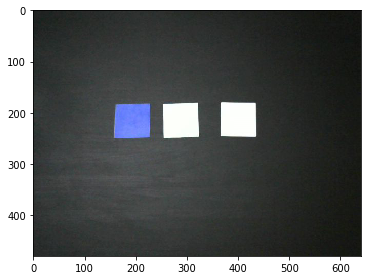

In [ ]:
#"""
#Use this code block to capture images through a webcam.
#Official snippet from Google, with a few modifications to remove excessive imports.
try:
  filename = take_photo()
  #print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  cap = io.imread(filename)
  io.imshow(cap)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
#"""

im = cap.copy()

#First extract the features
features_extracted = FeatureExtractor(im, bound_ratio=5.2, n_filtering=1,
                                      high_exposure=True,
                                      visualize=False,
                                      debugMode=False)

#At this point, the function to carry out the neural network will run:
#features_nn = FeatureNN(features_extracted)

#Then cluster the features
features_clustered = FeatureGeoClustering(features_extracted,debugMode=False)
#Then assign the id of the closest diagonal, vertical or horizontal line
#to the line fitted through the feature centroids
print(len(features_extracted))

In [ ]:
[f.color for f in features_extracted]

[array([[247.01638991, 249.92063834, 247.19150313]]),
 array([[246.04527979, 249.03161042, 244.77061085]]),
 array([[105.46496815, 128.33428509, 245.34263123]])]

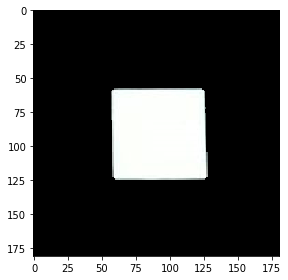

In [ ]:
features_extracted[0].imshow()

In [ ]:
features = FeatureLineFitting(features_clustered,debugMode=True,debugID=[0,1])

U Matrix:
 [[-0.56911168  0.09754495 -0.81645384]
 [-0.67801277 -0.61743199  0.39884387]
 [-0.46519951  0.78055283  0.41752448]]
Singular Values:
 [661.28803302  70.75052921]
VT Matrix:
 [[-0.56545704 -0.82477775]
 [ 0.82477775 -0.56545704]]
Directed angle of best fit line [degrees]: 124.43403474468441
Nearest principal axis angle: 135
Assigning Cluster: 0
Effect #ID's that are assigned: 3


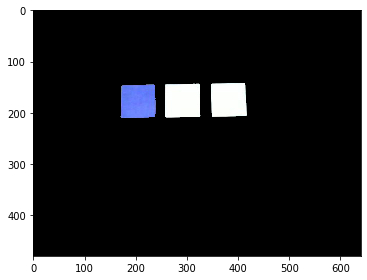

In [ ]:
#"""
reconst = ImageReconstruction(im,features_extracted)
io.imshow(reconst)
#"""

In [ ]:
print(f"Cluster list: {[f.cluster for f in features]}")

Cluster list: [0, 0, 0, 1, 1, 1]


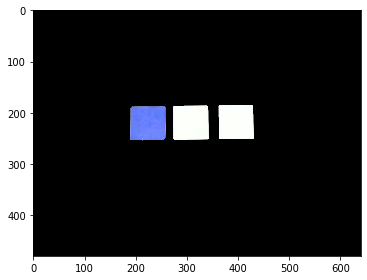

In [ ]:
"""
0: horizontal axis
1: left diagonal axis
2: vertical axis
3: right diagonal axis
"""
cluster_view = ImageReconstruction(im,[f for f in features_clustered if f.cluster==0])
io.imshow(cluster_view)

#Load Test Images from the Project Repository
Link to repo: https://gitlab.com/replicatesyndicate/me536_project

In [ ]:
%rm -r /content/me536_project/
!git clone https://gitlab.com/replicatesyndicate/me536_project.git

rm: cannot remove '/content/me536_project/': No such file or directory
Cloning into 'me536_project'...
remote: Enumerating objects: 3853, done.
remote: Counting objects: 100% (3853/3853), done.
remote: Compressing objects: 100% (3818/3818), done.
remote: Total 3853 (delta 35), reused 3852 (delta 34), pack-reused 0
Receiving objects: 100% (3853/3853), 186.45 MiB | 26.21 MiB/s, done.
Resolving deltas: 100% (35/35), done.
Checking out files: 100% (3820/3820), done.


#Calibration Parameters
Tweak these if things are going awry, pass them into the relevant functions as needed

In [ ]:
#VARIABLES FOR FUNCTION CALIBRATION
bound_ratio = 4 #use when calling FeatureExtractor
tolerance = 275 #use to calibrate clustering 
n_iterations = 3 #number of times the clustering is iterated

#Executing the entire block through a test image -- Clustering to find "New"
Not going through line fitting or clustering by position here!  
Clustering applications used in this block are only for feature vectors.

In [ ]:
#Obtain the images in this block

circle = []
hexagon = []
pentagon = []
square = []
star = []
triangle = [] 

mainpath = "/content/me536_project/_batch/"

path = mainpath + "circle"
for f in glob.iglob(path+"/*.png"):
  im = io.imread(f)
  circle.append(im)

path = mainpath + "hexagon"
for f in glob.iglob(path+"/*.png"):
  im = io.imread(f)
  hexagon.append(im)

path = mainpath + "pentagon"
for f in glob.iglob(path+"/*.png"):
  im = io.imread(f)
  pentagon.append(im)

path = mainpath + "square"
for f in glob.iglob(path+"/*.png"):
  im = io.imread(f)
  square.append(im)

path = mainpath + "star"
for f in glob.iglob(path+"/*.png"):
  im = io.imread(f)
  star.append(im)

path = mainpath + "triangle"
for f in glob.iglob(path+"/*.png"):
  im = io.imread(f)
  triangle.append(im)

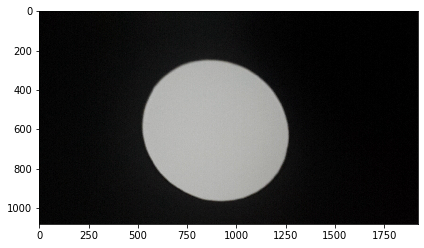

In [ ]:
io.imshow(circle[0])

In [ ]:
circle_features = []
hexagon_features = []
pentagon_features = []
square_features = []
star_features = []
triangle_features = []

print("Working on circles...")
for item in circle:
  #First extract the features
  features_extracted = FeatureExtractor(item)
  #Then cluster the features, according to their positions
  features_clustered = FeatureGeoClustering(features_extracted)
  #Then assign the id of the closest diagonal, vertical or horizontal line
  #to the line fitted through the feature centroids
  features = FeatureLineFitting(features_clustered)
  features_vectorized = VectorizeFeatures(features)
  circle_features.append(features_vectorized)

print("Working on hexagons...")
for item in hexagon:
  #First extract the features
  features_extracted = FeatureExtractor(item)
  #Then cluster the features, according to their positions
  features_clustered = FeatureGeoClustering(features_extracted)
  #Then assign the id of the closest diagonal, vertical or horizontal line
  #to the line fitted through the feature centroids
  features = FeatureLineFitting(features_clustered)
  features_vectorized = VectorizeFeatures(features)
  hexagon_features.append(features_vectorized)

print("Working on pentagons...")
for item in pentagon:
  #First extract the features
  features_extracted = FeatureExtractor(item)
  #Then cluster the features, according to their positions
  features_clustered = FeatureGeoClustering(features_extracted)
  #Then assign the id of the closest diagonal, vertical or horizontal line
  #to the line fitted through the feature centroids
  features = FeatureLineFitting(features_clustered)
  features_vectorized = VectorizeFeatures(features)
  pentagon_features.append(features_vectorized)

print("Working on squares...")
for item in square:
  #First extract the features
  features_extracted = FeatureExtractor(item)
  #Then cluster the features, according to their positions
  features_clustered = FeatureGeoClustering(features_extracted)
  #Then assign the id of the closest diagonal, vertical or horizontal line
  #to the line fitted through the feature centroids
  features = FeatureLineFitting(features_clustered)
  features_vectorized = VectorizeFeatures(features)
  square_features.append(features_vectorized)

print("Working on triangles...")
for item in triangle:
  #First extract the features
  features_extracted = FeatureExtractor(item)
  #Then cluster the features, according to their positions
  features_clustered = FeatureGeoClustering(features_extracted)
  #Then assign the id of the closest diagonal, vertical or horizontal line
  #to the line fitted through the feature centroids
  features = FeatureLineFitting(features_clustered)
  features_vectorized = VectorizeFeatures(features)
  triangle_features.append(features_vectorized)

print("Working on stars...")
for item in star:
  #First extract the features
  features_extracted = FeatureExtractor(item)
  #Then cluster the features, according to their positions
  features_clustered = FeatureGeoClustering(features_extracted)
  #Then assign the id of the closest diagonal, vertical or horizontal line
  #to the line fitted through the feature centroids
  features = FeatureLineFitting(features_clustered)
  features_vectorized = VectorizeFeatures(features)
  star_features.append(features)


Working on circles...
Working on hexagons...
Working on pentagons...
Working on squares...
Working on triangles...
Working on stars...


Image Number: 1,
        Averaged RGB values of feature: [[197.56621617 198.0951248  194.18520056]],
        Centroid: (473.1556717525925, 929.2262107316263),
        Perimeter: 3369.3161594775365,
        Area: 216873,
        Orientation [Radians]: -1.2013511355906434,
        Euler Number: 1,
        Compactness: 4.165509973456864,
        Top Left Corner: (0, 429),
        Bottom Right Corner: (973, 1429),
        Geometric Cluster: -1,
        Assigned Effect #ID: None,
        Feature Vector:,
         [[  1.        ]
 [  4.16550997]
 [197.56621617]
 [198.0951248 ]
 [194.18520056]]


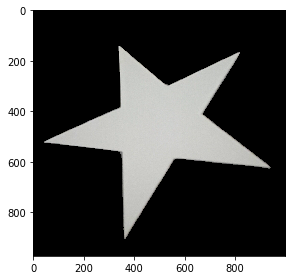

In [ ]:
#Check the procedure here
idx = 1
print(star_features[idx][0])
star_features[idx][0].imshow()

Image Number: 1,
        Averaged RGB values of feature: [[185.09724026 186.39421897 184.45353029]],
        Centroid: (617.7550476303705, 931.6724546359732),
        Perimeter: 2377.1282092113565,
        Area: 336445,
        Orientation [Radians]: 0.212681573353879,
        Euler Number: 1,
        Compactness: 1.336537871063271,
        Top Left Corner: (117, 431),
        Bottom Right Corner: (1080, 1431),
        Geometric Cluster: -1,
        Assigned Effect #ID: None,
        Feature Vector:,
         [[  1.        ]
 [  1.33653787]
 [185.09724026]
 [186.39421897]
 [184.45353029]]


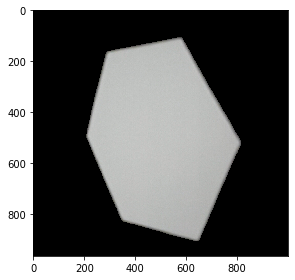

In [ ]:
#Check the procedure here, for another shape
idx = 1
print(hexagon_features[idx][0])
hexagon_features[idx][0].imshow()

In [ ]:
vectors = np.zeros((5,1)) #feature vectors here are of (5,1) shape
vectors_tri = np.zeros((5,1))

for f_list in circle_features:
  vectors = np.hstack((vectors,f_list[0].vector))

for f_list in hexagon_features:
  vectors = np.hstack((vectors,f_list[0].vector))

for f_list in pentagon_features:
  vectors = np.hstack((vectors,f_list[0].vector))

for f_list in square_features:
  vectors = np.hstack((vectors,f_list[0].vector))

for f_list in star_features:
  vectors = np.hstack((vectors,f_list[0].vector))

for f_list in triangle_features:
  vectors_tri = np.hstack((vectors,f_list[0].vector))

#get rid of zero vector 
vectors = vectors[:,1:]  
vectors_tri = vectors_tri[:,1:]

In [ ]:
print(vectors.shape) #there are 41 images, and their features vectors have 5 properties
print(vectors_tri.shape)

(5, 34)
(5, 35)


In [ ]:
#We will try to see where these land
vt_tri = vectors_tri.transpose()
vt_tri[0]

array([  1.        ,   1.15632561, 176.64992838, 176.7562934 ,
       174.18730588])

In [ ]:
#There are 6 classes of objects, let's try to cluster them as such
#to be able to pass this into KMeans, we need to transpose it
kmeans_features = KMeans(n_clusters=7).fit(vectors.transpose())
print(kmeans_features.labels_) #doesn't work...

[3 3 0 0 3 1 0 0 0 4 4 2 0 3 4 0 0 6 3 0 3 3 6 5 1 4 0 6 2 0 4 3 0 6]


In [ ]:
#Trying k-NearestNeighbors
neigh = NearestNeighbors(n_neighbors=3)
neigh.fit(vectors.transpose())

NearestNeighbors(algorithm='auto', leaf_size=30, metric='minkowski',
                 metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                 radius=1.0)

In [ ]:
#Expecting an answer, but an inconsistent one for different pictures
res=neigh.kneighbors(vt_tri,return_distance=False)

In [ ]:
res

array([[ 0, 21, 18],
       [ 1,  4,  0],
       [ 2, 19,  6],
       [ 3, 15, 17],
       [ 4, 20,  1],
       [ 5, 24, 30],
       [ 6,  7, 26],
       [ 7,  6, 26],
       [ 8, 26, 15],
       [ 9, 10, 14],
       [10, 14,  9],
       [11, 28, 27],
       [12,  6, 26],
       [13, 20,  4],
       [14, 10,  9],
       [15,  3,  7],
       [16,  2, 19],
       [17,  3, 15],
       [18, 21,  0],
       [19,  2,  6],
       [20,  4, 13],
       [21,  0, 18],
       [22, 27, 17],
       [23, 28, 11],
       [24, 30, 25],
       [25, 30,  9],
       [26,  8,  6],
       [27, 33, 22],
       [28, 11, 27],
       [29, 32, 19],
       [30, 25, 24],
       [31, 20,  4],
       [32, 29, 19],
       [33, 27, 22],
       [15,  8,  3]])

In [ ]:
#Get 3 circles this time
res_2 = neigh.kneighbors(vectors[:,0:4].transpose(),return_distance=False)

In [ ]:
res_2 #this one also doesn't work well

array([[ 0, 21, 18],
       [ 1,  4,  0],
       [ 2, 19,  6],
       [ 3, 15, 17]])

#Definitions for Functions and Classes
Run this block to define **all** functions and classes.  
Appropriate comments are written in the code here.  
If necessary, read more details about the implementation in the playground block below.

##Function definition for feature extraction and the Feature class
Run this block to enable the functions

In [ ]:
class Feature: 
  """
  The Feature class, to hold feature properties, and the image of the object.
  Some attributes may be used as neural network hyperparameters.
  Some attributes are required to find others (passed as None).
  Generate a Feature by first processing an image through FeatureExtractor.

  Dependencies: from skimage import io
                import numpy as np

  Attributes: Read the docstring of FeatureExtractor for more details.
              
              flushed_image:  The color image of the object bounded in a box,
                              with the background removed.
              
              vector: Feature vector obtained by the neural network.
              
              cluster: Clustering label, used to group objects that are near.
              
              sound: Sound file assigned to the feature. This could be an index
              pointing to the list of sound files, loaded along with training
              data for the neural network. The sound files will have new entries
              if the neural network recognizes the object as "new". 
              Left in for the speculative part of the project.
              
              effect_id: Sound effect assigned by the data analysis functions 
              to the feature. Could be a filter, reverb, reverse, etc. 
              Applicable to chords.
              Chords are objects clustered by their centroid distances.

  Methods:    imshow(): calls io.imshow() to view the flushed image.
  """
  def __init__(self, index, color, centroid, perimeter, area, orientation, 
               euler_number, compactness, corner_topleft, corner_botright, 
               flushed_image, vector=None, cluster=None, effect_id=None, 
               sound=None):
    self.index = index
    self.color = color
    self.centroid = centroid
    self.perimeter = perimeter
    self.area = area
    self.orientation = orientation
    self.euler_number = euler_number
    self.compactness = compactness
    self.corner_topleft = corner_topleft
    self.corner_botright = corner_botright
    self.flushed_image = flushed_image
    self.vector = vector
    self.cluster = cluster
    self.effect_id = effect_id
    self.sound = sound

  def __str__(self):
    return (
        f'''Image Number: {self.index},
        Averaged RGB values of feature: {self.color},
        Centroid: {self.centroid},
        Perimeter: {self.perimeter},
        Area: {self.area},
        Orientation [Radians]: {self.orientation},
        Euler Number: {self.euler_number},
        Compactness: {self.compactness},
        Top Left Corner: {self.corner_topleft},
        Bottom Right Corner: {self.corner_botright},
        Geometric Cluster: {self.cluster},
        Assigned Effect #ID: {self.effect_id},
        Feature Vector:,
         {self.vector}'''
        
    )
  
  def imshow(self):
    #Returns the feature's "flushed" image, i.e. with zero-background
    #https://github.com/scikit-image/scikit-image/blob/master/skimage/io/_io.py#L139-L159
    return io.imshow(self.flushed_image)

In [ ]:
def VectorizeFeatures(features):
  """
  Take in a Feature class object and generate the appropriate feature vector for
  it. Will require modifications as more features are added (speculative part).
  """
  for f in features:
    f.vector = np.array([
                [f.euler_number],
                [f.compactness],
                [f.color[0][0]],
                [f.color[0][1]],
                [f.color[0][2]]
                ])
  return features

In [ ]:
def FeatureExtractor(image, bound= 500, n_filtering = 2, visualize=False,
                     high_exposure=True,debugMode=False):
  
  """
  Extract from an image, the features on the foreground of the image and their
  attributes. 
  Requires a Feature class to function. 

  Dependencies: import skimage
                import numpy as np
                import scipy.ndimage as ndi
                import skimage.morphology as morphology
                from skimage.filters import threshold_otsu
                from skimage import io
                from skimage import measure
                import matplotlib.pyplot as plt
                from skimage.color import rgb2gray

  Note:
  Can be also used on grayscale images without failure, but the original image
  will be then a grayscale one, when the isolated image is shown; and the color 
  values will be for the grayscale image.

  Inputs: numpy.ndarray (3D RGB image, or 2D grayscale image)
          
          bound_ratio (float) - Removed (see previous notebooks): 
          Defines how large the bounding window will be. 
          Explicitly defines the ratio of the feature's area to its 
          circumference. Recommended value is 4, and the minimum possible value 
          is 3.6. Going lower may cause clipping.

          bound (int) - Replacement for the bound_ratio method of framing object
          images. Fixed value, therefore requires tweaking for larger objects.

          n_filtering(int): The number of iterations for the filtering.

          visualize (bool): True - enable plots for the feature extraction 
          process, to debug in case additional features appear due to 
          inadequate filtering. Defaults to False.

          high_exposure(bool): True - enable gamma correction on the image to
          get a high exposure image. Useful for dark features that don't appear
          after the filtering.

          debugMode (bool): True - Enable debug outputs. Defaults to False.

  Outputs:  feature_idx (list, int) - List of object label numbers

            colors (list, numpy.ndarray) - List of feature colors in RGB

            centroids (list, float) - List of object centroid positions 
            on original image.

            perimeters (list, float) - List of feature perimeters
            
            areas (list, float) - List of feature areas
            
            orientations (list, float) - List of feature orientations. 
            The CCW angle with the positive horizontal axis is given in radians.
            
            euler_numbers (list, float) - List of feature Euler Numbers 
            (8-neighbors).
            
            TL_corners (list, tuple, int) - List of object top left corner
            index positions, on original image. 
            Useful for bounding box generation.
            
            BR_corners (list, tuple, int) - List of object bottom right corner
            index positions, on original image. 
            Useful for bounding box generation.
  """

  #Load in the image, and get grayscale
  im = image.copy()
  gray = rgb2gray(im)

  #Apply Gamma exposure to grayscale image
  gray_exp = gray.copy()
  if high_exposure == True:
    gray_exp = exposure.adjust_gamma(gray_exp,gamma=0.35, gain=1)

  #Binarization, using Otsu's thresholding method
  thresh = threshold_otsu(gray_exp)

  binary = gray_exp > thresh 

  #Salt and pepper noise is to be removed inside the objects

  fill_objects = binary.copy()

  #Filter multiple times if required
  for _ in range(n_filtering):
    fill_objects = morphology.binary_erosion(fill_objects)
    fill_objects = ndi.binary_fill_holes(fill_objects)
    fill_objects = morphology.binary_opening(fill_objects)
    fill_objects = morphology.binary_closing(fill_objects)
    fill_objects = morphology.binary_dilation(fill_objects)
  
  labels = measure.label(fill_objects, background = 0)
  if debugMode == True:
    print(f"The number of features recognized:{labels.max()}") 
    #should be equal to the number of objects on the picture

  #Using connected component labeling tools of skimage
  props = measure.regionprops(labels)
  
  features = []

  feature_idx = []
  colors = []
  centroids = []
  perimeters = []
  areas = []
  orientations = []
  euler_numbers = []
  compactnesses = []
  TL_corners = []
  BR_corners = []

  for label_pick in range(1,labels.max()+1):
    centroid = props[label_pick-1].centroid
    perimeter = props[label_pick-1].perimeter
    area = props[label_pick-1].area
    orientation = props[label_pick-1].orientation
    euler_number = props[label_pick-1].euler_number #8-neighbors
    compactness = (perimeter**2/area)/(4*np.pi) #defined in class

    #Get a trimmed off image
    feature = np.zeros_like(labels)
    feature = np.where((labels==label_pick),labels,0)
    trimmed = feature.copy()

    #initialize boundaries
    bound_top = 0
    bound_bot = feature.shape[0]
    bound_left = 0
    bound_right = feature.shape[1]

    #using fixed frame sizes, see previous notebooks for variable frame sizes.
    center = tuple([int(centroid[0]),int(centroid[1])])

    if center[0]-bound > 0:
      bound_top = int(center[0]-bound)
    else:
      bound_top = 0

    if center[0]+bound < im.shape[0]:
      bound_bot = int(center[0]+bound)
    else:
      bound_bot = im.shape[0]

    if center[1]-bound > 0:
      bound_left = int(center[1]-bound)
    else:
      bound_left = 0

    if center[1]+bound < im.shape[1]:
      bound_right = int(center[1]+bound)
    else:
      bound_right = im.shape[1]

    trimmed = feature[bound_top:bound_bot,bound_left:bound_right]
    #plt.imshow(trimmed, cmap="nipy_spectral")

    im_trimmed = im[bound_top:bound_bot,bound_left:bound_right].copy()
    im_flushed = im_trimmed.copy()

    im_flushed[:,:,0] = np.where(trimmed==label_pick, im_trimmed[:,:,0], 0)
    im_flushed[:,:,1] = np.where(trimmed==label_pick, im_trimmed[:,:,1], 0)
    im_flushed[:,:,2] = np.where(trimmed==label_pick, im_trimmed[:,:,2], 0)

    feature_color = np.zeros((1,3))

    red_flushed = im_flushed[:,:,0]
    green_flushed = im_flushed[:,:,1]
    blue_flushed = im_flushed[:,:,2]

    feature_color[:,0] = red_flushed[red_flushed.nonzero()].mean()
    feature_color[:,1] = green_flushed[green_flushed.nonzero()].mean()
    feature_color[:,2] = blue_flushed[blue_flushed.nonzero()].mean()

    if debugMode == True:
      print(f"Image Number: {label_pick}")
      print(f"Averaged RGB values of feature: {feature_color}")
      print(f"Centroid: {centroid}")
      print(f"Perimeter: {perimeter}")
      print(f"Area: {area}")
      print(f"Orientation [Radians]: {orientation}")
      print(f"Euler Number: {euler_number}")
      print(f"Compactness: {compactness}")
      print(f"Top Left Corner: {(bound_top,bound_left)}")
      print(f"Bottom Right Corner: {(bound_bot,bound_right)}")
    """
    if isClass == False:
      feature_idx.append(label_pick)
      colors.append(feature_color)
      centroids.append(centroid)
      perimeters.append(perimeter)
      areas.append(area)
      orientations.append(orientation)
      euler_numbers.append(euler_number)
      compactnesses.append(compactness)
      TL_corners.append((bound_top,bound_left))
      BR_corners.append((bound_bot,bound_right)) 
    
    if isClass == True:
    """
    features.append(Feature(label_pick,feature_color,centroid,perimeter,area,
                            orientation,euler_number,compactness,
                            (bound_top,bound_left),
                            (bound_bot,bound_right),im_flushed))


    if visualize == True:
      plt.figure(figsize=(18, 7))
      plt.subplot(151, title="Denoised Binary")
      plt.imshow(fill_objects, cmap='gray')
      plt.axis('off')
      plt.subplot(152, title= "All labels")
      plt.imshow(labels, cmap='nipy_spectral')
      plt.axis('off')
      plt.subplot(153, title= "Grayscale image")
      plt.imshow(gray, cmap='gray')
      plt.axis('off')
      plt.subplot(154, title= "Isolated image")
      plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral")
      plt.axis('off')
      plt.subplot(155, title= f"Flushed feature image: {label_pick}")
      plt.imshow(im_flushed, cmap="nipy_spectral")
      plt.axis('off')
  """
  if isClass == False:
    return (feature_idx, colors, centroids, perimeters, areas, orientations, 
          euler_numbers, compactnesses, TL_corners, BR_corners)
  elif isClass == True:
  """
  return features

In [ ]:
def ImageReconstruction(img,features,binary=False):
  """
  
  Inputs: img [ndarray] - original image
          features [Features](list) - list of Feature class objects
          binary [bool] - enable to see binary image instead

  Reconstructs the original photograph, with backgrounds removed and object
  images filtered. Is useful to determine if there are issues related to feature
  extraction from the image, due to hardware/filtering related problems.
  """
  canvas = np.zeros_like(img)

  for f in features:
    canvas[f.corner_topleft[0]:f.corner_botright[0],f.corner_topleft[1]:
           f.corner_botright[1]] += f.flushed_image.copy()
  
  if binary == True:
    canvas_gray = rgb2gray(canvas)
    thresh_canvas = threshold_otsu(canvas_gray)
    binary = canvas_gray > thresh_canvas
    return binary

  return canvas

##Singular Value Decomposition to Fit a Singular Vector Between the Centroids
Run this block to enable the functions

In [ ]:
def PrincipalOrientation(features, debugMode = False):
  """
  A simple function that takes in a cluster of three features from an image to 
  fit a line among their centroids, using Singular Value Decomposition. 
  
  Returns the "axis of principal orientation" (this word is made up) 
  that this line is the closest to.
  In this implementation, the principal orientation axes are defined to be the:
    0: horizontal axis
    1: left diagonal axis
    2: vertical axis
    3: right diagonal axis

  Dependencies: Feature class
                import numpy as np

  Inputs: features (list, Feature class) -- A list of 3 features from the image.
          debugMode (bool) -- Toggle to display debug information.

  Outputs: dex -- The index of the nearest principal axis, among 4.
  """
  
  #Grab the centroid positions from the features
  centroids = np.zeros((len(features),2))
  for idx in range(len(features)):
    centroids[idx][0] = features[idx].centroid[0]
    centroids[idx][1] = features[idx].centroid[1]
    
  #Defining the principal axes. 
  #Since fitted lines won't have a sense of direction,
  #most values will be paired together for the labeling
  principals = [0,45,90,135,180,225,270,315]

  u, s, vt = np.linalg.svd(centroids, full_matrices=True)
  if debugMode == True:
    print(f"U Matrix:\n {u}")
    print(f"Singular Values:\n {s}")
    print(f"VT Matrix:\n {vt}")

  ang=np.abs(np.arctan2(vt[0][1],vt[0][0])*180/np.pi)
  if debugMode == True:
    print(f"Directed angle of best fit line [degrees]: {ang}")
  
  if debugMode == True:
    print(f"Nearest principal axis angle: {principals[(np.abs(principals-ang)).argmin()]}")
  dex = (np.abs(principals-ang)).argmin()
  if dex >= 4:
    dex -= 4
  
  return dex  

##Clustering with the KMeans algorithm
Run this block to enable the functions

In [ ]:
def DistanceEuclidean(features):
  """
  Returns the Euclidean distance among the centroids of
  given two objects. Only returns the distance between
  the first two list items.
  
  Input: features (list, Feature class)
  Output: distance_euclidean (float)
  """
  #obtain centroid indices by list comprehension
  c = [f.centroid for f in features]
  #compute Euclidean distance
  distance_euclidean = ((c[0][0]-c[1][0])**2+(c[0][1]-c[1][1])**2)**0.5

  return distance_euclidean

In [ ]:
def FeatureGeoClustering(features_extracted,tolerance=275,n_iterations=3,debugMode=False):
  """
  Dependencies: def distanceEuclidean
                class Feature
                import numpy as np
                from sklearn.cluster import KMeans

  Inputs: features_extracted (list of Feature class instances) - objects to be clustered
          tolerance (float) - maximum centroid distance allowed within a cluster
          n_iterations (int) - number of iterations to check centroid distances
          debugMode (bool) - toggle to enable debug information

  Outputs: fcl (list of Feature class instances) - updated features with cluster labels

  Note: There will be a cluster label (label value -1) that is 
  for anything that cannot be clustered for the given conditions.
  This cluster of discarded objects will be treated as individual ones.
  Validated clusters of objects will have positive label values and can be
  grouped together by calling Feature.cluster
  """

  #Dividing the number of objects by three and taking ceiling to generate the  
  #number of maximum possible valid clusters
  n_clusters = np.ceil(len(features_extracted)/3).astype(int)
  if debugMode == True:
    print(f"Expected maximum number of clusters:{n_clusters}")

  kmeans = KMeans(n_clusters = n_clusters).fit([f.centroid for f in features_extracted])

  #Got the first guesses on the clusters, using KMeans!
  for idx in range(len(features_extracted)):
    features_extracted[idx].cluster = kmeans.labels_[idx]
  if debugMode == True:
    print(f"List of initial cluster labels:{[f.cluster for f in features_extracted]}")
  
  #creating shorthand name for convenience
  fcl = features_extracted.copy()

  #Now it is required to "detach" some of these items from the clusters
  #may need to run this multiple times, just like KMeans
  for _ in range(n_iterations):
    
    for i in range(n_clusters):
      #iterate through cluster labels that KMeans printed out

      #store elements of this cluster label in this list
      cls = []
      #go through the feature list to store them in cls
      for f in fcl:
        if f.cluster == i:
          cls.append(f)
      
      #now cleaning up the clustering according to the distances

      #if there are more than 2 elements, check distances
      if len(cls) > 2:
        for j in range(len(cls)): #compare this element with others 

          off_range = True #unless it is proved that they are close, they are not
          
          for k in range(len(cls)): 
            if j!=k: #don't compare it with itself
              dist = DistanceEuclidean([cls[j],cls[k]]) #get Euclidean distance
              if debugMode == True:
                print(f"Comparing: {cls[j].index} with {cls[k].index}. Dist: {dist}")
              if dist < tolerance: 
                off_range = False #if within tolerance, it's not off-range
          
          #if it is off-range, it doesn't belong to this cluster
          if off_range == True:
            #group it with the other discarded items
            cls[j].cluster = -1

          if debugMode == True:
            print(f"Index: {cls[j].index}, off_range: {off_range}")
      
      else: #if less than 3 elements, discard entire cluster proposition
        for elem in cls: 
          elem.cluster = -1

    if debugMode == True:
      print([f.cluster for f in fcl])

  return fcl  

##Passing Clusters into Data Analysis Functions
Run this block to enable the function

In [ ]:
def FeatureLineFitting(features_clustered,debugID=[0,0],debugMode=False):
  """
  A function to pass feature lists with clustering information, to obtain
  the closest diagonal, horizontal or vertical line that passes nearest to the
  best fit lines of each cluster.

  This function must be called after using GeoClustering.

  Inputs: features_clustered (list of Feature class instances)
  Outputs: features_analyzed (list of Feature class instances)
  """

  #copying over the clustered features list
  features_analyzed = features_clustered.copy()

  #the end condition for the for loop:
  n_cluster_iter = max([f.cluster for f in features_clustered])+1

  for i in range(n_cluster_iter):
    #pick all cluster elements of the given non-negative label
    cluster_elems = [f for f in features_analyzed if f.cluster == i]
    #use data analysis to fit a line, and select closest line representing 
    #the effect_id of this "chord"
    effect_id = PrincipalOrientation(cluster_elems,debugMode=(i in debugID))
    #assign this effect_id to all elements
    for elem in cluster_elems:
      elem.effect_id = effect_id
  
    if (debugMode == True):
      print(f"Assigning Cluster: {i}")
      print(f"Effect #ID's that are assigned: {effect_id}")
      #features_analyzed[i].imshow() #don't want to flood the screen with images
    
  return features_analyzed

#Playground for All
Some testing is done in the blocks hidden here, may be explanatory in certain ways.

## Playground for Feature Extraction

In [ ]:
#features = FeatureExtractor(im) #quite snappy, and quite neat!

In [ ]:
"""
#added a method call - Feature.imshow() which calls io.imshow,
#on the flushed image.

print(features[2])
features[2].imshow()
"""

##Playground before function implementation

In [ ]:
#io.imshow(im)

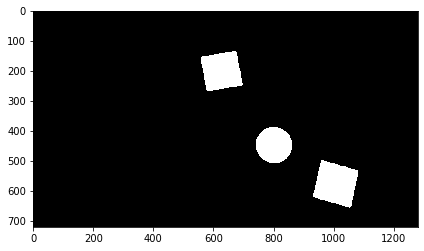

In [ ]:
"""
#Binarization, using Otsu's thresholding method
thresh = threshold_otsu(gray)
binary = gray > thresh 
io.imshow(binary)
"""

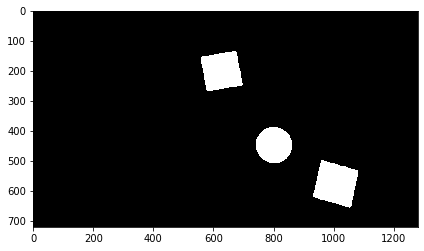

In [ ]:
"""
#Salt and pepper noise is to be removed inside the objects
#Use erosion,dilation,opening,closing to remove noise exterior to the objects is necessary

fill_objects = binary.copy()

fill_objects = morphology.binary_erosion(fill_objects)
fill_objects = ndi.binary_fill_holes(fill_objects)
fill_objects = morphology.binary_closing(fill_objects)
fill_objects = morphology.binary_dilation(fill_objects)
io.imshow(fill_objects)
"""

In [ ]:
"""
#labels = measure.label(fill_objects)
labels = measure.label(fill_objects, background = 0)

plt.figure(figsize=(9, 3.5))
plt.subplot(131)
plt.imshow(fill_objects, cmap='gray')
plt.axis('off')
plt.subplot(132)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
plt.subplot(133)
plt.imshow(labels, cmap='nipy_spectral')
plt.axis('off')
"""

In [ ]:
"""
print(labels.max()) #should be equal to the number of objects on the picture
"""

In [ ]:
"""
##PLAY AROUND WITH THIS IF FEATURES CANNOT BE PROPERLY FRAMED!
bound_ratio = 4

#Using connected component labeling tools of skimage
props = measure.regionprops(labels)

centroids = []
perimeters = []
areas = []
orientations = []
euler_numbers = []

#TODO FOR FUNCTION
#Iterate through 1 to len(props)!
##
label_pick = 1
##

centroid = props[label_pick-1].centroid
perimeter = props[label_pick-1].perimeter
area = props[label_pick-1].area
orientation = props[label_pick-1].orientation
euler_number = props[label_pick-1].euler_number #8-neighbors
#euler_number_4 = measure.euler_number(img_labels[label_pick-1], connectivity=4) #4-neighbors
#print(skimage.measure.regionprops.__doc__) #read here for more

compactness = (perimeter**2/area)/(4*np.pi) #defined in class

#Show the specified feature
#find label on label image, put it on the foreground, make the rest of the image the background
#plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral") 

#Get a trimmed off image
feature = np.zeros_like(labels)
feature = np.where((labels==label_pick),labels,0)
trimmed = feature.copy()

#initialize boundaries
bound_top = 0
bound_bot = feature.shape[0]
bound_left = 0
bound_right = feature.shape[1]

#unindent to use
  #use zero row/cols -- not really a good idea
  for row in range(feature.shape[0]):
    bound_top = 0
    if (feature[row,:]==0).all() == True:
      bound_top = row
    else:
      break

  for row in range(feature.shape[0]-1,0,-1):
    bound_bot = feature.shape[0]-1
    if (feature[row,:]==0).all() == True:
      bound_bot = row
    else:  
      break

  for col in range(feature.shape[1]):
    bound_left = 0
    if (feature[:,col]==0).all() == True:
      bound_left = col
    else:
      break

  for col in range(feature.shape[0]-1,0,-1):
    bound_right = feature.shape[0]-1
    if (feature[:,col]==0).all() == True:
      bound_right = col
    else:
      break


  #use bounded frames derived from centroid position, area, and perimeter data
  #quite effective in bounding anything at all - details in the formulation below
  bound = (area/perimeter)*bound_ratio
  center = tuple([int(centroid[0]),int(centroid[1])])

  if center[0]-bound > 0:
    bound_top = int(center[0]-bound)
  else:
    bound_top = 0

  if center[0]+bound < im.shape[0]:
    bound_bot = int(center[0]+bound)
  else:
    bound_bot = im.shape[0]

  if center[1]-bound > 0:
    bound_left = int(center[1]-bound)
  else:
    bound_left = 0

  if center[1]+bound < im.shape[1]:
    bound_right = int(center[1]+bound)
  else:
    bound_right = im.shape[1]

trimmed = feature[bound_top:bound_bot,bound_left:bound_right]
#plt.imshow(trimmed, cmap="nipy_spectral")

im_trimmed = im[bound_top:bound_bot,bound_left:bound_right].copy()
im_flushed = im_trimmed.copy()

im_flushed[:,:,0] = np.where(trimmed==label_pick, im_trimmed[:,:,0], 0)
im_flushed[:,:,1] = np.where(trimmed==label_pick, im_trimmed[:,:,1], 0)
im_flushed[:,:,2] = np.where(trimmed==label_pick, im_trimmed[:,:,2], 0)

feature_color = np.zeros((1,3))

red_flushed = im_flushed[:,:,0]
green_flushed = im_flushed[:,:,1]
blue_flushed = im_flushed[:,:,2]

feature_color[:,0] = red_flushed[red_flushed.nonzero()].mean()
feature_color[:,1] = green_flushed[green_flushed.nonzero()].mean()
feature_color[:,2] = blue_flushed[blue_flushed.nonzero()].mean()

print(f"Feature Number: {label_pick}")
print(f"Averaged RGB values of feature: {feature_color}")
print(f"Centroid: {centroid}")
print(f"Perimeter: {perimeter}")
print(f"Area: {area}")
print(f"Orientation [Radians]: {orientation}")
print(f"Euler Number: {euler_number}") #blobs should yield a one I guess?
print(f"Compactness: {compactness}")
print(f"Top Left Corner: {(bound_top,bound_left)}")
print(f"Bottom Right Corner: {(bound_bot,bound_right)}")

#plt.imshow(np.where((labels==label_pick),labels,0), cmap="nipy_spectral")
#px.imshow(im)
#plt.imshow(trimmed, cmap="nipy_spectral")
#px.imshow(im_trimmed)
plt.imshow(im_flushed, cmap="nipy_spectral")
"""

In [ ]:
#px.imshow(im_flushed)

In [ ]:
"""
#Explanation on why bound = (area/perimeter)*4
#where bound = side/2
#Note: only regular shapes will be used as features in the demo!

side = 10000
bound = side/2

circle_area = 0.25*np.pi*(side**2)
circle_perimeter = np.pi*side
circle_param = circle_area/circle_perimeter

square_area = side**2
square_perimeter = 4*side
square_param = square_area/square_perimeter

triangle_area = 0.4330127*side**2
triangle_perimeter = 3*side
triangle_param = triangle_area/triangle_perimeter

print(circle_param)
print(square_param)
print(triangle_param)

#safe to work with +-triangle_param*3.5~4 from centroid?
print(bound/triangle_param)
print(bound/square_param)
"""

##Playground for SVD, and testing

In [ ]:
"""
#Playground for the function

dex = PrincipalOrientation(features,debugMode=True)
print(dex)
"""

U Matrix:
 [[-0.40198239  0.91388599  0.0567676 ]
 [-0.56818082 -0.20034225 -0.79814381]
 [-0.71803949 -0.35309402  0.59978655]]
Singular Values:
 [1614.01345208  122.11205444]
VT Matrix:
 [[-0.4643618  -0.88564559]
 [-0.88564559  0.4643618 ]]
Directed angle of best fit line [degrees]: 152.33107331133553
Nearest principal axis angle: 135
3


##Playground for testing the clustering algorithm

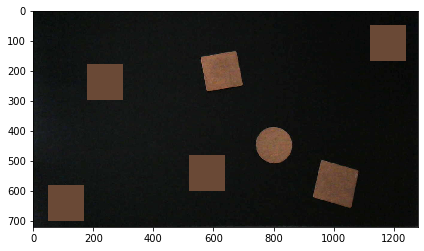

In [ ]:
"""
#Generating a test image for clustering demos

#io.imshow(test_image)
#Using the binary image from the feature extraction playground
#io.imshow(fill_objects)
im_cluster= im.copy()

#Adding in 4 more squares to play with
im_cluster[180:300,180:300] = [106.5400915,73.5848784,54.51492897]
im_cluster[480:600,520:640] = [106.5400915,73.5848784,54.51492897]
im_cluster[50:170,1120:1240] = [106.5400915,73.5848784,54.51492897]
im_cluster[580:700,50:170] = [106.5400915,73.5848784,54.51492897]
io.imshow(im_cluster)
"""

In [ ]:
"""
#get the features for this demo
features_clustering = FeatureExtractor(im_cluster)
"""

In [ ]:
"""
#GeoClustering demo
features_clustered = GeoClustering(features_clustering)
idx = 6
print(features_clustered[idx])
features_clustered[idx].imshow()
print([f.cluster for f in features_clustered])
"""

###Some more playing around for debugging and testing

In [ ]:
"""
#Dividing the number of features by three and taking ceiling to generate the  
#number of maximum possible valid clusters
n_clusters = np.ceil(len(features_clustering)/3).astype(int)
print(n_clusters)
print(type(n_clusters))
"""

3
<class 'numpy.int64'>


In [ ]:
"""
#Now taking the centroid positions to cluster them
centroids_clustering = [f.centroid for f in features_clustering]
print(centroids_clustering)
"""

[(109.5, 1179.5), (202.46778613082273, 626.4627977236), (239.5, 239.5), (447.5560776124598, 800.8126685808753), (539.5, 579.5), (576.3977811094453, 1006.4244677661169), (639.5, 109.5)]


In [ ]:
#kmeans = KMeans(n_clusters = n_clusters).fit([f.centroid for f in features_clustering])

In [ ]:
#kmeans.labels_

array([1, 0, 2, 0, 0, 0, 2], dtype=int32)

In [ ]:
"""
#There are three clusters as designated,
#One cluster has an extra square, that we want to get rid of
#That square is the topmost "original" square at idx = 1
#Other clusters are worthless, so we gather them together later as well
idx = 1

print(features_clustering[idx])
features_clustering[idx].imshow()
"""

##Testing the Clustering+SVD function

In [ ]:
#features_analyzed = LineFittingClusters(features_clustered)

In [ ]:
"""
print(f"Clusters that were assigned: {[f.cluster for f in features_analyzed]}")
print(f"Effect #ID's that are assigned: {[f.effect_id for f in features_analyzed]}")
"""

##Calibration of the filtering process
For FeatureExtractor  
Apparently, for blue and red images, some exposure is required in low light areas. Added the functionality with a flag called `high_exposure`.

<IPython.core.display.Javascript object>

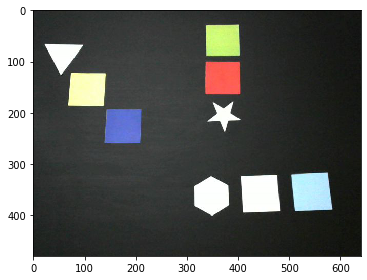

In [ ]:
"""
#Use this code block to capture images through a webcam.
#Official snippet from Google, with a few modifications to remove excessive imports.
try:
  filename = take_photo()
  #print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  cap = io.imread(filename)
  io.imshow(cap)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))
"""

In [ ]:
"""
n_filtering = 2
high_exposure = True

#Load in the image, and get grayscale
im_filt = cap.copy()
gray = rgb2gray(im)

#Apply Gamma exposure to grayscale image
gray_exp = gray.copy()
if high_exposure == True:
  gray_exp = exposure.adjust_gamma(gray_exp,gamma=0.2, gain=1)

#Binarization, using Otsu's thresholding method
thresh = threshold_otsu(gray_exp)

binary = gray_exp > thresh 

#Salt and pepper noise is to be removed inside the objects

fill_objects = binary.copy()

for _ in range(n_filtering):
  fill_objects = morphology.binary_erosion(fill_objects)
  fill_objects = ndi.binary_fill_holes(fill_objects)
  fill_objects = morphology.binary_opening(fill_objects)
  fill_objects = morphology.binary_closing(fill_objects)
  fill_objects = morphology.binary_dilation(fill_objects)
"""

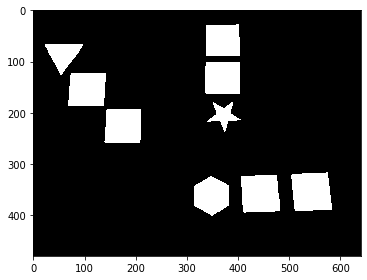

In [ ]:
#io.imshow(binary)

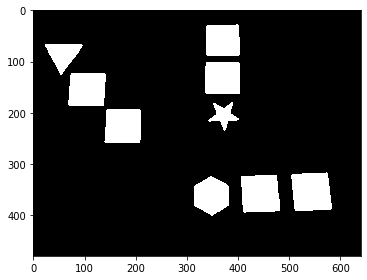

In [ ]:
#io.imshow(fill_objects)